# Covid19 notebook. People hostipalized in Spain.
In this notebook, I try to analyze data from covid19 in Spain. I examine the variation of people hospitalized by covid19. We use data from the Spanish government download from https://covid19.isciii.es/resources/serie_historica_acumulados.csv

In [14]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import pycountry

In [54]:
url = 'https://covid19.isciii.es/resources/serie_historica_acumulados.csv'
sz_column_ca = "CCAA Codigo ISO"
file_encoding = 'cp1252' 
columns_use = ["CCAA Codigo ISO","Fecha","Hospitalizados"]

In [36]:
def plot(dates, value, title= "", file_to_save=None):
    #plt.title('My title')
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.plot(dates ,value)
    fig.autofmt_xdate()
    if file_to_save is not None:
        fig.savefig(file_to_save)
    


In [49]:
def ca_get_name(code):
    try:
        st=pycountry.subdivisions.get(code='ES-' + code)
        return (st.name.split(',')[0].split('/')[0])  
    except:
        return code 

## Get data 
Get panda dataframe with data about covid19 in Spain from the Spanish government.

In [58]:
r = requests.get(url, allow_redirects=True)
open('serie_historica_acumulados.csv', 'wb').write(r.content)
df_read = pd.read_csv("serie_historica_acumulados.csv", encoding=file_encoding)
df = df_read[columns_use].copy()
df["Date"] = pd.to_datetime(df["Fecha"], format='%d/%m/%Y')
df = df.dropna()


In [60]:
# Create data to all Spain (df_es) and Galician(df_ga)
df_ga=df[df[sz_column_ca]=="GA"]
df_es=df.groupby("Date").sum()
df_es["Date"]=df_es.index

In [61]:
print("Date from {0} to {1}".format(df["Date"].min().date(),df["Date"].max().date()))

Date from 2020-03-10 to 2020-04-05


## Plot data from Spain and Galician

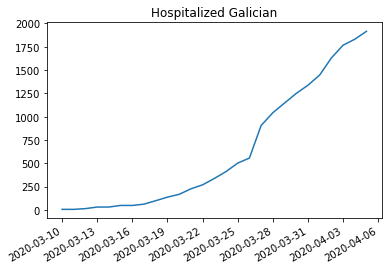

In [62]:
plot(df_ga["Date"] , df_ga["Hospitalizados"], title="Hospitalized Galician")

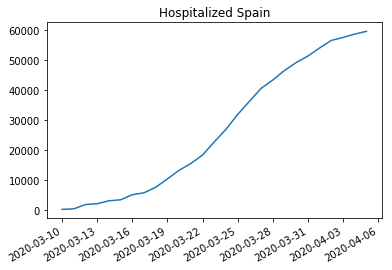

In [63]:
plot(df_es["Date"] , df_es["Hospitalizados"], title="Hospitalized Spain")

In [64]:
diff_hospitalized_spain = df_es["Hospitalizados"] - df_es["Hospitalizados"].shift(1)
diff_hospitalized_galician = df_ga["Hospitalizados"] - df_ga["Hospitalizados"].shift(1)

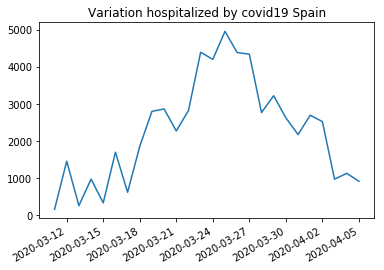

In [65]:
plot(df_es["Date"], 
     diff_hospitalized_spain, 
     title="Variation hospitalized by covid19 Spain", 
     file_to_save="VariationSpain")

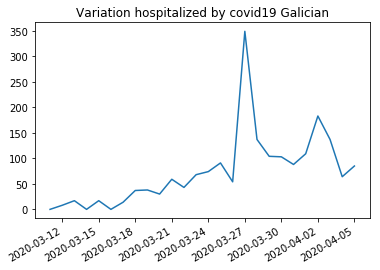

In [66]:
plot(df_ga["Date"], 
     diff_hospitalized_galician, 
     title="Variation hospitalized by covid19 Galician", 
     file_to_save="VariationGalician")

## Plot data by community

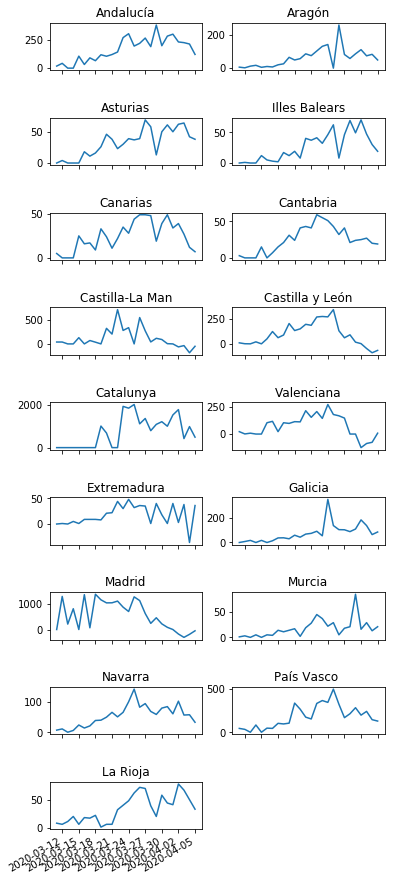

In [67]:
lst_ca=list(df[sz_column_ca].unique())
lst_ca.remove("CE")
lst_ca.remove("ME")
n_columns=2
n_rows= math.ceil(len(lst_ca) /  n_columns)
fig, ax = plt.subplots( n_rows , 
                       n_columns)
for ca in lst_ca:
    index=lst_ca.index(ca)
    column = math.floor(index/n_columns)
    row = index - column * n_columns
    df_tmp = df[df[sz_column_ca] == ca]    
    diff = (df_tmp["Hospitalizados"] - 
                                df_tmp["Hospitalizados"].shift(1))
    ax[column, row].set_title(ca_get_name(ca)[:15])
    ax[column, row].plot(df_tmp["Date"], diff)
plt.subplots_adjust(top=3, hspace=1)
fig.autofmt_xdate()
if len(lst_ca) %2 != 0:
    fig.delaxes(ax[ n_rows -1, n_columns - 1] )
plt.show()
fig.savefig("desglose.png", format='png')


In [51]:
df

,CCAA Codigo ISO,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados,Unnamed: 7,Date
0,AN,20/02/2020,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-20
1,AR,20/02/2020,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-20
2,AS,20/02/2020,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-20
3,IB,20/02/2020,1.0,NaN,NaN,NaN,NaN,NaN,2020-02-20
4,CN,20/02/2020,1.0,NaN,NaN,NaN,NaN,NaN,2020-02-20
5,CB,20/02/2020,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-20
6,CM,20/02/2020,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-20
7,CL,20/02/2020,0.0,NaN,NaN,NaN,NaN,NaN,2020-02-20
8,CT,20/02/2020,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-20
9,CE,20/02/2020,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-20
